In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px

from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import matplotlib.patheffects as pe
palette_plotly = px.colors.qualitative.Plotly

In [2]:
run_id = "ca8ff65afb5744a2bde060f116d70a22"

best_epoch = 9

In [3]:
folder = os.path.join(
    "../mlruns/8",
    run_id,
    "artifacts/predictions"
)

df = []

for epoch, filename in enumerate(sorted(os.listdir(folder))):

    filename_full = os.path.join(folder, filename)
    
    df_epoch = pd.read_csv(filename_full, index_col=0)
    df_epoch["epoch"] = epoch

    df.append(df_epoch)

df = pd.concat(df)

In [4]:
reducer = UMAP(n_components=2, random_state=42)
pipeline_umap = make_pipeline(StandardScaler(), reducer)

In [5]:
columns = [c for c in df if c.startswith("emb")]
Z = pipeline_umap.fit_transform(df[columns])

In [6]:
df["x"] = Z[:, 0]
df["y"] = Z[:, 1]

In [7]:
df_best = df[df.epoch == best_epoch].copy()

px.scatter(
    df_best,
    x="x",
    y="y",
    color="label_true",
    symbol="fold",
    # color="proba_pred_artdeco",
    width=600,
    height=400
)

In [1]:
epochs = [0, 1, best_epoch, 49]

fig, axes = plt.subplots(ncols=len(epochs), nrows=2, figsize=(8, 4), dpi=100, sharex=True, sharey=True)

for epoch, axes_col in zip(epochs, axes.T):

    mask_epoch = df.epoch == epoch

    for label_code in range(8):

        mask_label = df.label_code_true == label_code

        color = palette_plotly[label_code]

        mask_train = df.fold == "train"
        df_plot = df[mask_epoch & mask_train & mask_label]
        x = df_plot.x
        y = df_plot.y

        plt.sca(axes_col[0])
        plt.title(f"epoch = {epoch}", size="small")
        plt.plot(x, y, ".", color=color)

        if epoch == epochs[-1]:
            label = df_plot.label_true.iloc[0]
            plt.text(
                x.mean(),
                y.mean(),
                label,
                ha="center",
                va="center",
                size="xx-small",
                path_effects=[pe.withStroke(linewidth=2, foreground="white")]
            )


        df_plot = df[mask_epoch & ~mask_train & mask_label]
        x = df_plot.x
        y = df_plot.y

        plt.sca(axes_col[1])
        # plt.plot(x, y, ".", color="w", zorder=10)
        plt.plot(x, y, ".", color=color, zorder=10)

for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks([])
    plt.yticks([])

    for spine in ax.spines.values():
        spine.set_color("0.9")

axes[0, 0].set_ylabel("train")
axes[1, 0].set_ylabel("test")

plt.tight_layout()

# plt.savefig(f"../images/embedding-evolution-{run_id}.png", facecolor="white", dpi=300)

NameError: name 'best_epoch' is not defined

In [14]:
filename = "../data/predictions/train_nn_classifier/ca8ff65afb5744a2bde060f116d70a22/best_embedding_2d.csv"

# df_best.to_csv(filename, index=False)

# Clustering

In [27]:
from itertools import product

import pandas as pd

import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline

from umap import UMAP

from tqdm import tqdm

import os

import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px

from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import matplotlib.patheffects as pe
palette_plotly = px.colors.qualitative.Plotly

In [43]:
run_id = "ca8ff65afb5744a2bde060f116d70a22"

In [2]:
filename = os.path.join(
    "../data/predictions/train_nn_classifier",
    run_id,
    "best_embedding_2d.csv"
)

df_best = pd.read_csv(filename)

In [4]:
columns = [c for c in df_best if c.startswith("emb")]

In [5]:
# umaper = UMAP(n_neighbors=15, min_dist=0.5, n_components=2, random_state=41)
# pipeline_umap = make_pipeline(StandardScaler(), umaper)

# Z = pipeline_umap.fit_transform(df_best[columns])
# X_umap = pipeline_umap.fit_transform(Z)

In [6]:
# clusterizer = AgglomerativeClustering(n_clusters=5).fit(Z)
# label_cluster = pd.Series(clusterizer.labels_, dtype="category")

In [7]:
clusterizer = AgglomerativeClustering(n_clusters=8).fit(df_best[["x", "y"]])
label_cluster = pd.Series(clusterizer.labels_, dtype="category")

In [8]:
px.scatter(
    x=df_best.x,
    y=df_best.y,
    # color=df_best["label_true"],
    color=label_cluster,
    width=500,
    height=400,
    # hover_data={"i": df.index, "fold": df.fold_author}
).show()

In [9]:
X = df_best[["x", "y"]]

In [10]:
methods = KMeans, AgglomerativeClustering
names = "kmeans", "agglomerative"
kws = {"random_state": 42}, {}

groups = zip(methods, names, kws)

n_clusters_list = range(2, 12)

items = product(n_clusters_list, groups)

rows = []

for item in tqdm(list(items)):
    
    n_clusters, (method, name, kw) = item

    clusterizer = method(n_clusters=n_clusters, **kw).fit(X)

    label_cluster = pd.Series(clusterizer.labels_, dtype="category")
    score = silhouette_score(X, label_cluster)
    row = {
        "n_clusters": n_clusters,
        "name": name,
        "silhouette_score": score
    }
    rows.append(row)

100%|██████████| 20/20 [00:01<00:00, 17.76it/s]


In [11]:
df_scores = pd.DataFrame(rows)

In [12]:
px.scatter(
    df_scores,
    x="n_clusters",
    y="silhouette_score",
    color="name",
    width=500,
    height=300
)

In [20]:
clusterizer = AgglomerativeClustering(n_clusters=8).fit(df_best[["x", "y"]])
label_cluster = pd.Series(clusterizer.labels_, dtype="category")

In [24]:
clusterizer = KMeans(n_clusters=8, random_state=42).fit(df_best[["x", "y"]])
label_cluster = pd.Series(clusterizer.labels_, dtype="category")

In [25]:
px.scatter(
    x=df_best.x,
    y=df_best.y,
    # color=df_best["label_true"],
    color=label_cluster,
    width=500,
    height=400,
    # hover_data={"i": df.index, "fold": df.fold_author}
).show()

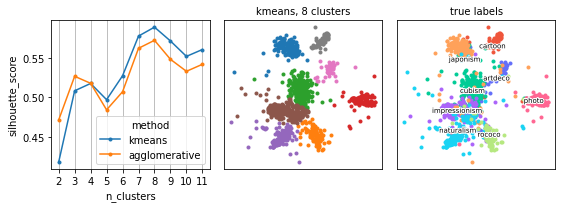

In [44]:
fig, axes = plt.subplots(ncols=3, figsize=(8, 3))

plt.sca(axes[0])

for name in df_scores.name.unique():

    mask = df_scores.name == name
    x = df_scores.loc[mask, "n_clusters"]
    y = df_scores.loc[mask, "silhouette_score"]

    plt.plot(
        x,
        y,
        ".-",
        label=name
    )

plt.xticks(n_clusters_list)
plt.grid(axis="x")
plt.legend(title="method")

plt.xlabel("n_clusters")
plt.ylabel("silhouette_score")

x = df_best.x
y = df_best.y

plt.sca(axes[1])
plt.title("kmeans, 8 clusters", size="medium")

for cluster_id in range(8):
    mask = label_cluster == cluster_id
    plt.plot(x[mask], y[mask], ".")

plt.sca(axes[2])
plt.title("true labels", size="medium")

for label_code in range(8):

    mask_label = df_best.label_code_true == label_code
    color = palette_plotly[label_code]

    label = df_best[mask_label].label_true.iloc[0]

    plt.plot(x[mask_label], y[mask_label], ".", color=color)

    plt.text(
        x[mask_label].mean(),
        y[mask_label].mean(),
        label,
        ha="center",
        va="center",
        size="x-small",
        path_effects=[pe.withStroke(linewidth=2, foreground="white")]
    )

for ax in axes[1:].flatten():
    plt.sca(ax)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

plt.savefig(f"../images/embedding-clustering-{run_id}.png", facecolor="white", dpi=300)

# ArcFaceLoss

In [8]:
run_id = "60721c74bc834d52a53f486ff813d08c"

In [9]:
filename = os.path.join(
    "../mlruns/9",
    run_id,
    "artifacts/predictions/data-099.csv"
)
df = pd.read_csv(filename, index_col=0)

In [10]:
X = df[["x", "y", "z"]]

In [11]:
import numpy as np

In [12]:
Z = X / np.linalg.norm(X, axis=1, keepdims=True)

In [15]:
fig = px.scatter_3d(
    x=X.x,
    y=X.y,
    z=X.z,
    color=df["true"]
)

fig.show()

In [16]:
filename = f"../images/arccos-native-{run_id}.html"
fig.write_html(filename)

In [13]:
fig = px.scatter_3d(
    x=Z.x,
    y=Z.y,
    z=Z.z,
    color=df["true"]
)

fig.show()

In [14]:
filename = f"../images/arccos-sphere-{run_id}.html"
fig.write_html(filename)